In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

/Users/theoares/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
config = '24I/ml_0p01'
# config = '24I/ml_0p005'
# config = '32I/ml0p008'
# config = '32I/ml0p006'
# config = '32I/ml0p004'
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/SD_output.h5'
n_ops = 5

In [3]:
f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['pion-00WW'][()]
C3pt_tavg = f['C3pt'][()]    # TODO now these should all be bootstrapped
Cnpt = f['Cnpt'][()]
# R = f['R'][()]
R_boot = f['R'][()]
f.close()
# n_files = Cnpt.shape[0]

In [4]:
# R_boot = bootstrap(R)
R_μ = np.mean(R_boot, axis = 0)
R_σ = np.std(R_boot, axis = 0, ddof = 1)

It looks like David may have found a few regions to fit at each sep: in ml0p004/fits/xml/O1.xml, he is specifying the following regions: 

sep | (tmin, tmax)

15  | (7, 8)

16  | (7, 9)

17  | (7, 10)

18  | (7, 11)

19  | (7, 12)

20  | (7, 13)

...

25  | (7, 18)

So as sep moves up, he increases the maximum fitting range for the data at sep by 1.

TRY TO REPLICATE SOME OF THE PLOTS IN 24I/ml_0p01/fits/results/plots-- see if I can get O1.19 to look the same, and O2.21

Note that I believe these are already jackknifed, i.e. the data in pion_0vbb_4quark_2p.3.1540 for example has already been resampled. This means I shouldn't expect them to match completely, but rather I should expect them to be within statistical error. The second (weight) column also matches up with the resampled uncertainty, as if you evaluate $R_\sigma$ for the corresponding time slice, it compares well to the data in the uncertainty column.

O1.19 matches if I divide my output by 4?
At SEP = 21 (in the filename), so far I've checked that O2, O3, O1p, and O2p match one another. 

TODO why doesn't O1 match up? My O1 that I've saved has to be divided by 4 to match David's graph, although each other operator is fine.

In [5]:
# # Plot C3(t, 2t) / C2(2t)
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, 2 * t]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, 2 * t]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [6]:
# # Plot C3(t, sep) / C2(sep)
# sep = 21
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, sep]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, sep]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [7]:
# Try to replicate the plots in 24I/ml_0p01/plots, this is what is generated by plot_pion_0vbb_4quark_ratios.py
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
# data_slice = np.zeros((n_files, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_μ = np.mean(data_slice, axis = 0)
data_plot_σ = np.std(data_slice, axis = 0, ddof = 1)

<IPython.core.display.Javascript object>


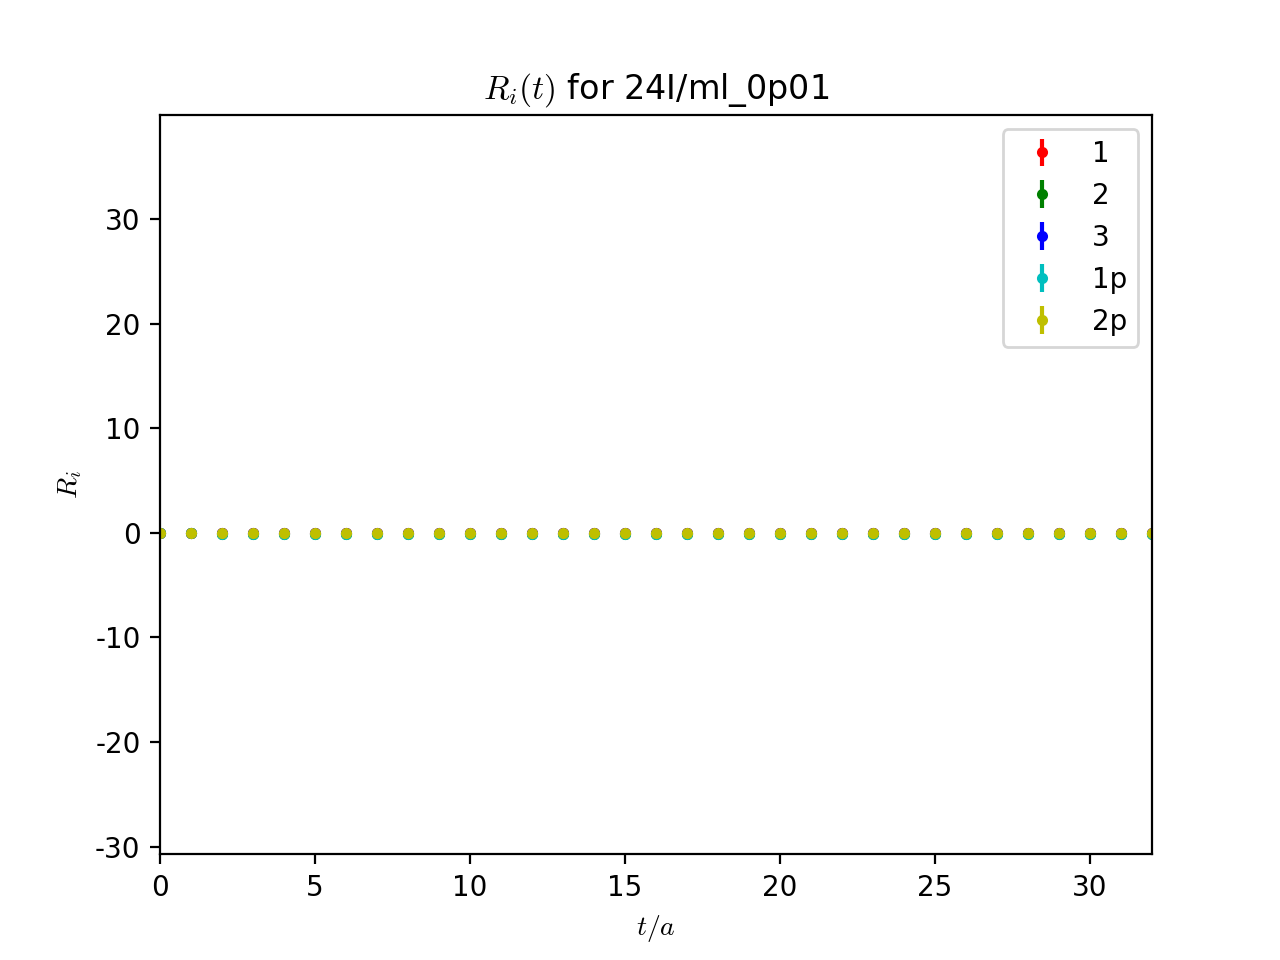

In [8]:
# Plotting R(t, 2t), so need to truncate the graph and data at T // 2
plt.figure()
colors = ['r', 'g', 'b', 'c', 'y']
op_label = ['1', '2', '3', '1p', '2p']
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = op_label[i])
plt.title('$R_i(t)$ for ' + config)
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
# plt.xlim((0, 21.5))
plt.xlim((0, T // 2))
# plt.xlim((0, T))
# plt.ylim((0.00022, 0.00035))
plt.legend()
plt.show()

In [9]:
# plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/' + config + '/O3_t_2t.pdf'
# plt.savefig(plt_path)

In [10]:
# # fit each linear region to a constant by fitting over a region
# fit_regions = [
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26)
# ]
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
# for i in range(n_ops):
#     fits[:, i] = fit_constant(fit_regions[i], data_slice[:, i])[0]
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

In [11]:
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
f_acc = []
stats_acc = []
meff_acc = []
weights = []
c = [0, 0, 0, 0, 0]
σc = [0, 0, 0, 0, 0]
for i in range(n_ops):
    results = fit_constant_allrange(data_slice[:, i, : (T // 2)])
    f_acc.append(results[0])
    stats_acc.append(results[1])
    meff_acc.append(results[2])
    weights.append(results[3])
    c[i], σc[i] = analyze_accepted_fits(results[2], results[3])
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
196 range(8, 12) 0.01707384961199654 -0.04504023033749523 0.00026581995324922883 241633.02854297298
216 range(9, 13) 0.11893401655387206 -0.04538113309406001 0.0002937024279980727 1378767.41893328
217 range(9, 14) 0.10911135945749473 -0.04545876475807502 0.0002998590309828727 1213488.5991088457
218 range(9, 15) 0.09444273497102952 -0.04552776707625604 0.0003038369650404506 1023027.5671683752
219 range(9, 16) 0.05791422122858387 -0.04560018745092582 0.000307810062327847 611251.0175371716
220 range(9, 17) 0.04658150223117493 -0.0456525241297999 0.00031263107393631167 476594.69648680807
221 range(9, 18) 0.03236484741127024 -0.045707693011558054 0.00031474823399955997 326698.3640576912
222 range(9, 19) 0.01643099102760489 -0.04576348394007637 0.00031846412772419035 162010.33453918318
223 range(9, 20) 0.011752407328620929 -0.04580863103952108 0.00032068481258804726 114279.95225618797
235 range(10, 14) 0.6961425

318 range(15, 22) 0.9905561287201134 -0.04630697411713552 0.0003575934939895704 7746399.163949903
319 range(15, 23) 0.9960427325025514 -0.046319404351372453 0.0003553855134900263 7886395.073378867
320 range(15, 24) 0.998714101942365 -0.04631969380656985 0.00035512932716777663 7918959.1948657185
321 range(15, 25) 0.9995365997295097 -0.046326995988573774 0.0003536079605784357 7993824.957980205
322 range(15, 26) 0.9996680762501181 -0.046342035981245505 0.000353787172131515 7986778.857772205
323 range(15, 27) 0.9998134406534553 -0.04635323128748231 0.00035475571150096 7944383.088800885
324 range(15, 28) 0.9997694880340927 -0.046370364184996314 0.0003546708802678415 7947834.456822968
325 range(15, 29) 0.9998676476502542 -0.04638023230931327 0.00035544345528032455 7914098.881778772
326 range(15, 30) 0.9998738228662197 -0.04639440006021798 0.00035498488518510715 7934607.986085915
327 range(15, 31) 0.9996892575280423 -0.04641368252404496 0.0003549894379509654 7932939.862677556
328 range(16, 20

402 range(25, 31) 0.998015565502974 -0.046573192269690346 0.00037458918212495286 7112574.896234758
403 range(26, 30) 0.9968226353017635 -0.04655315831675159 0.00037760713799863587 6990971.000087629
404 range(26, 31) 0.9937553463406332 -0.04658859337216599 0.0003772539460246133 6982515.298206349
405 range(27, 31) 0.9844040103402003 -0.04661179125434534 0.0003774894880255434 6908180.073710838
Number of accepted fits: 180
Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
55 range(2, 6) 0.011304193221541324 -0.07144241685742654 0.0004883673027428065 47396.51542756631
153 range(6, 10) 0.0232058953611179 -0.07568407343267475 0.0006167539315019199 61006.270555165735
175 range(7, 11) 0.10007012930353379 -0.07655709153421299 0.0006426059577185294 242334.34302026298
176 range(7, 12) 0.02362224043586992 -0.07685837038216298 0.0006513121691882344 55685.573951336315
196 range(8, 12) 0.13011492767380783 -0.07722892622130983 0.000661392758810525 297446.082264518
197 ran

295 range(13, 26) 0.9631583225033351 -0.07960448502898582 0.0007594042922353456 1670135.0358167437
296 range(13, 27) 0.9646645802497303 -0.07964812213718042 0.0007582131258067461 1678006.875042158
297 range(13, 28) 0.9577445676355613 -0.07969846971748845 0.000756275083382435 1674519.1287264365
298 range(13, 29) 0.9597768639953798 -0.07973661996393103 0.0007548674394005452 1684336.6206264324
299 range(13, 30) 0.9553403054053017 -0.07977978393320619 0.000753202502975286 1683970.936277648
300 range(13, 31) 0.9387025186317578 -0.07983008923207904 0.0007499476469886275 1669037.4804702061
301 range(14, 18) 0.9493986785390452 -0.07920001900968814 0.0007582683512651181 1651211.7237117002
302 range(14, 19) 0.9311320121084228 -0.0793164357395162 0.0007633460752660215 1597968.8304185495
303 range(14, 20) 0.9529352714893843 -0.07938758221873461 0.0007622717830468329 1639999.4951851773
304 range(14, 21) 0.9536152898854449 -0.0794656648971117 0.0007647370764198222 1630605.5378218542
305 range(14, 22

397 range(24, 29) 0.9970887069869415 -0.08023402230412614 0.0007731171952643569 1668180.852473622
398 range(24, 30) 0.9986773851788339 -0.08027397583903728 0.0007723425928446491 1674191.9288175122
399 range(24, 31) 0.9982278190248117 -0.08033193057898558 0.0007679452843437734 1692657.5900588783
400 range(25, 29) 0.9979028032342964 -0.08029510688335924 0.0007783262130026305 1647270.5277571902
401 range(25, 30) 0.9991816543415181 -0.08033114901689663 0.0007764897961046923 1657192.4478542088
402 range(25, 31) 0.9985413636142481 -0.08038949221462581 0.0007711188905835325 1679281.0026577055
403 range(26, 30) 0.9961373232974083 -0.0803564214632113 0.0007757390031471983 1655342.8490833894
404 range(26, 31) 0.9955447284843171 -0.08042081761661396 0.0007702566791799907 1677991.7884541731
405 range(27, 31) 0.9906218577661793 -0.08047139384525505 0.0007733533176269546 1656349.5742332384
Number of accepted fits: 200
Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
2

302 range(14, 19) 0.9811434622759273 0.002762171223890468 1.6695526934268333e-05 3519915624.9224076
303 range(14, 20) 0.9948726041881735 0.00276220680954528 1.6700173308721133e-05 3567184034.551211
304 range(14, 21) 0.9978410717320342 0.0027629721257282558 1.6603678633246996e-05 3619534644.8222256
305 range(14, 22) 0.9986932828385655 0.0027637745081405198 1.6714716591760658e-05 3574654680.1393776
306 range(14, 23) 0.999579697004106 0.0027641069367246997 1.666254686297357e-05 3600266576.2156515
307 range(14, 24) 0.9998407895720556 0.0027636629793216017 1.6557444478114736e-05 3647071145.872991
308 range(14, 25) 0.9999542119436632 0.0027638584789540866 1.647113781961704e-05 3685809727.243699
309 range(14, 26) 0.9999620284044028 0.002764461821729791 1.6553810258837027e-05 3649115107.04432
310 range(14, 27) 0.9999796195592406 0.0027648947035316417 1.6652106756853208e-05 3606224634.9139776
311 range(14, 28) 0.9999844308822047 0.002765403537002833 1.6705063571312745e-05 3583413891.8095245
312

387 range(22, 28) 0.9944092999390791 0.002767868244099474 1.7840949354343502e-05 3124131145.636705
388 range(22, 29) 0.9982878107743495 0.0027683005599479426 1.8017434016506908e-05 3075175371.5911827
389 range(22, 30) 0.9991884428258296 0.00276908179116218 1.7985046506556986e-05 3089045261.5558305
390 range(22, 31) 0.9995963285519112 0.0027697782913368 1.7955788033673838e-05 3100385609.333805
391 range(23, 27) 0.955470926815561 0.0027668565766140697 1.7870200552179495e-05 2991979570.725605
392 range(23, 28) 0.9800974095031301 0.002768074221872101 1.8087071860010612e-05 2995937252.874943
393 range(23, 29) 0.9937386807772661 0.0027685588935274863 1.8294228053172407e-05 2969231215.0615497
394 range(23, 30) 0.997258219977311 0.0027694289687339203 1.8257508759699765e-05 2991745106.4818854
395 range(23, 31) 0.9987497807832936 0.00277018353901151 1.822650328080544e-05 3006422277.023081
396 range(24, 28) 0.9893711229401683 0.0027705665179538473 1.8503433589275817e-05 2889712116.125979
397 rang

297 range(13, 28) 0.9865762489288015 -0.14306815882017584 0.0010932418094966466 825464.1020110619
298 range(13, 29) 0.9895454831362815 -0.1431071960984281 0.001095145572853618 825072.3953366774
299 range(13, 30) 0.9896108222792072 -0.14315873307191318 0.0010938780088345214 827040.2634984802
300 range(13, 31) 0.9843243918467411 -0.14322262723291534 0.001093640585686628 822979.4853954437
301 range(14, 18) 0.9472739375805372 -0.14248268603982284 0.001086169977214456 802934.2804839173
302 range(14, 19) 0.9211389290244165 -0.14265724735468643 0.0010968339866615922 765673.0101753855
303 range(14, 20) 0.9514807701253549 -0.14274776873310846 0.0010963144346131987 791643.6834272785
304 range(14, 21) 0.9570735467309822 -0.14285263256098948 0.0010988882869583964 792571.0849032887
305 range(14, 22) 0.9687483107869072 -0.1429262129922918 0.0011071895664905506 790254.5209146265
306 range(14, 23) 0.9817463483627983 -0.1429770874793346 0.0011022351963534463 808073.2774964407
307 range(14, 24) 0.991567

394 range(23, 30) 0.9983081230151996 -0.1436603271961731 0.0011540297536750184 749601.7514908958
395 range(23, 31) 0.9970931142762485 -0.143752840786871 0.0011548373279340243 747642.6888803828
396 range(24, 28) 0.9846080055418701 -0.14367410692438942 0.0011532658585556765 740294.447402357
397 range(24, 29) 0.9969311120471549 -0.14369443760297432 0.0011605204855046332 740217.8054385899
398 range(24, 30) 0.998853145308956 -0.1437480348470664 0.0011565146712682762 746791.4696671349
399 range(24, 31) 0.9976899764301584 -0.14384215514401089 0.0011575799178646276 744549.6113023749
400 range(25, 29) 0.9977838736962189 -0.1437909195213294 0.0011779274913490837 719116.6842689106
401 range(25, 30) 0.9994100876907731 -0.14383635937893352 0.0011694921585032852 730716.8134312301
402 range(25, 31) 0.9979408123112871 -0.1439340784811021 0.0011690661332784504 730174.4377562576
403 range(26, 30) 0.9968579776668451 -0.1438715220689299 0.0011778234235025934 718576.3424846475
404 range(26, 31) 0.993629157

289 range(13, 20) 0.9328081787013126 0.019349710104108436 0.00018591138505878434 26988600.979131058
290 range(13, 21) 0.9276913975387361 0.01936883496380908 0.00018646333026151545 26681894.115649562
291 range(13, 22) 0.9301982526732457 0.019384554497083102 0.00018735180822476155 26500846.179089878
292 range(13, 23) 0.9414918554025057 0.019397645094678617 0.00018667385816520146 27017773.736687753
293 range(13, 24) 0.9617983966637886 0.01940464687329324 0.00018638278065773544 27686781.627376143
294 range(13, 25) 0.9699462536268127 0.019414581509269436 0.00018551989911490288 28181666.488796405
295 range(13, 26) 0.969243351970606 0.019426309300691107 0.0001855272754251317 28159004.50911569
296 range(13, 27) 0.9709657600242053 0.019436728394879442 0.00018515755684697226 28321811.76552112
297 range(13, 28) 0.9655867572022319 0.01944871024181981 0.0001846872659208296 28308535.12666203
298 range(13, 29) 0.967811757271773 0.019457735252385196 0.00018434202457321224 28480144.465833314
299 range(

373 range(20, 27) 0.9998586342761006 0.01952830541475127 0.00018983886537356708 27743953.13854021
374 range(20, 28) 0.9997604787011112 0.019539665038806345 0.00018920109001406573 27928569.810269613
375 range(20, 29) 0.9998955199342779 0.019546015310770864 0.00018885171855312629 28035786.236855518
376 range(20, 30) 0.9999008749398948 0.01955485065655078 0.0001884480731409268 28156167.87996659
377 range(20, 31) 0.9997574317112816 0.01956676624302663 0.0001875154095300506 28432871.06892396
378 range(21, 25) 0.9977418861189282 0.019509228215956884 0.00019002030660155653 27632372.55635076
379 range(21, 26) 0.9979464871107946 0.019521831010956482 0.0001902345315039605 27575827.09764199
380 range(21, 27) 0.9992273301291447 0.01953032372828949 0.0001894371630476513 27844148.51721531
381 range(21, 28) 0.9990701643317945 0.01954293702748802 0.00018891160622069853 27994886.3271637
382 range(21, 29) 0.9996330978523783 0.019549639482852498 0.0001886640742468161 28084209.842684213
383 range(21, 30) 

In [12]:
# order 1, 2, 3, 1p, 2p
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
print(config)
for i in range(n_ops):
    print(labels[i] + ': ' + str(c[i]) + ' \pm ' + str(σc[i]))

24I/ml_0p01
O1: -0.04629561796216235 \pm 0.0003997422481552316
O2: -0.07966717379958868 \pm 0.0009176876095929674
O3: 0.0027669560600221688 \pm 1.7224604838059174e-05
O1p: -0.14305483895282578 \pm 0.0012542706387783297
O2p: 0.01943832720760978 \pm 0.0002228354358644061


<IPython.core.display.Javascript object>


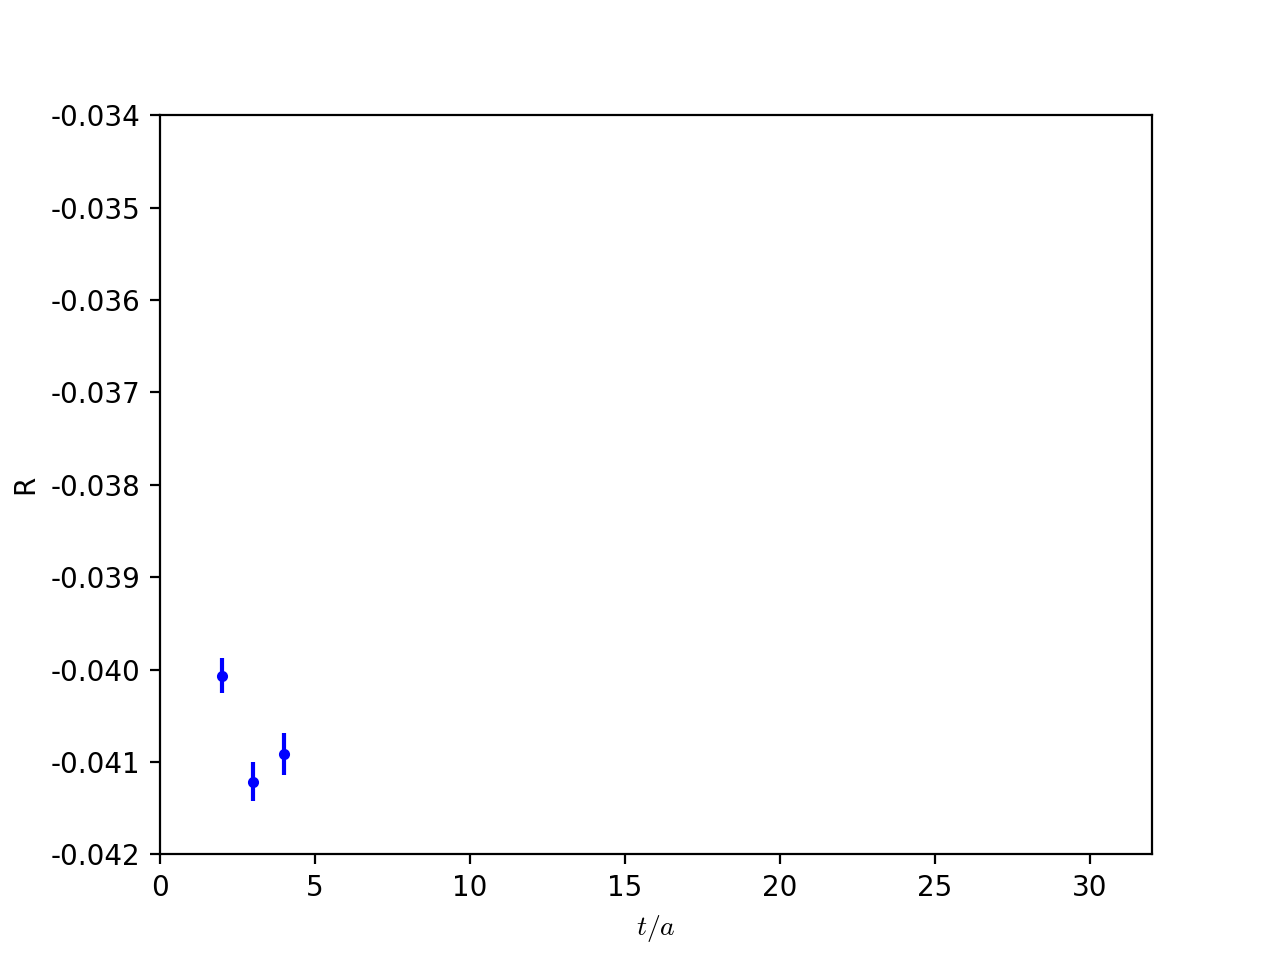

In [13]:
i = 0
plt.figure()
plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = 'b', label = op_label[i])
# plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = 'r', alpha = 0.3)
plt.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = 'r', alpha = 0.3)
# plt.title('$\mathcal{O}_2\'$')
plt.xlabel('$t / a$')
plt.ylabel('R')
plt.xlim((0, T // 2))
plt.ylim((-0.042, -0.034))
# plt.ylim((-0.05, -0.038))
# plt.ylim((-0.082, -0.068))
# plt.legend()
plt.show()

In [14]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/grad_student_lunch_club/O1.pdf')

<IPython.core.display.Javascript object>


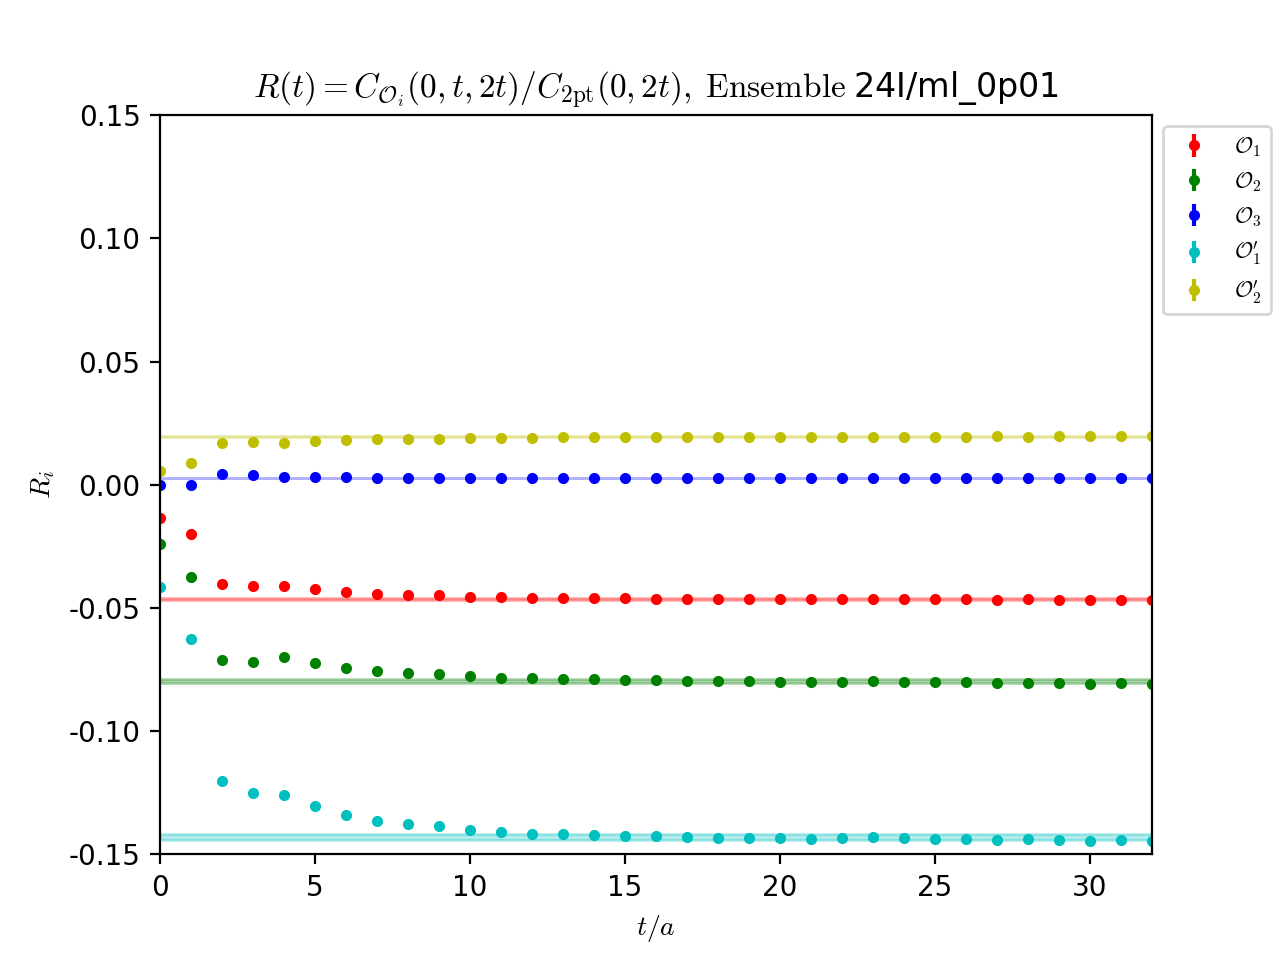

In [15]:
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']
plt.figure()
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    #plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
    plt.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \;$' + config)
# plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \; 24I/a m_{\ell} = 0.01.$')
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
plt.xlim((0, T // 2))
plt.ylim((-0.15, 0.15))
# plt.ylim((-0.042, -0.034))
# plt.ylim((-0.001, 0.025))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
plt.show()

In [32]:
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']

fig, ax = plt.subplots(figsize=[6, 4])

for i in range(n_ops):
    ax.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    ax.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
ax.set_title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; 24I/a m_{\ell} = 0.01.$', fontsize = 14)
ax.set_xlabel('$t / a$', fontsize = 18)
ax.set_ylabel('$R_i$', fontsize = 18)
ax.set_xlim((0, T // 2))
ax.set_ylim((-0.15, 0.15))
ax.set_xticklabels(Fontsize=16)
# plt.ylim((-0.042, -0.034))
# plt.ylim((-0.001, 0.025))
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 10})
# plt.show()

# axins = zoomed_inset_axes(ax, 6, loc = 2)
# bbox = Bbox([[5, 0.05], [30, 0.125]])
# bbox = Bbox([[0, 0], [1, 1]])
# axins = zoomed_inset_axes(ax, 1, loc = 2, bbox_to_anchor = (5, 0.05, 20, 0.05))
axins = inset_axes(ax, width="30%", height="30%", loc='upper left',
                   bbox_to_anchor=(0.1, -0.04, 2.55, 1), bbox_transform=ax.transAxes)
for i in range(n_ops):
    axins.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    axins.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
# axins.set_xlim((3, 30))
# axins.set_ylim((-0.048, -0.040))
axins.set_xlim((7, 31))
axins.set_ylim((-0.048, -0.044))
plt.xticks(visible=False)
plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

plt.draw()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

In [29]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/24I/ml_0p01/poster_figure.pdf')

In [18]:
# fit_plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/O3_t_2t.pdf'
# plt.savefig(fit_plt_path)

In [19]:
# fit_region_mat = np.array([[t for t in fit_regions[i]] for i in range(n_ops)])
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits
# # fout['fitrange'] = fit_regions
# # fout['fitrange'] = fit_region_mat
# fout.close()

24I/ml0p005
Using fit ranges, here are the results:
O1: -0.03904959592888694 \pm 0.0003288716824284383
O2: -0.0666878741764023 \pm 0.0008544848691336499
O3: 0.001394680973543252 \pm 1.304461961634588e-05
O1p: -0.12236700304358335 \pm 0.0010250036443713053
O2p: 0.016331963334146417 \pm 0.00021078791537872642

24I/ml0p005
Averaging over all fit ranges, this is what we get:
O1: -0.03895617532910957 \pm 0.0003514538198650905
O2: -0.06639419443067024 \pm 0.0009314932148826224
O3: 0.0013964752427535559 \pm 1.3311962233598224e-05
O1p: -0.12208471872628748 \pm 0.0010925713079177164
O2p: 0.016254775174429376 \pm 0.0002400637769421278